# RFI Mitigation using Machine Learning

# Process Pipeline

<img src="rfi_mitigation_diagram2.png">

## Basic Concept
 We here come up with a RFI mitigation pipeline that can be used to remove RFI Signals, we make use of a mix between two methods. We make use of a post-corellation rfi classification method simlar to that use by Offringa et al. (2010) and also make use of the methods brought forward by Mosiane et al. (2017). The aim of the whole pipeline is to flag and remove the RFI from the frequency-time dynamic spectra once the signal from each pair of antenna have been correlated.
 
In this Ipython notebook, we simulate those dynamic spetra. This is described in section 2 . The RFI are then added to the dynamic spectra these are data simulated by O'Shea et al.(2017). We will then do a detailed performance evaluating of our feature extraction mechanism and machine learning algorithm.

**1. Spectral Simulator** :The spectral simulation creates the corellated response function of each baselines. The Observations are made every 1 second for 3 Hours and from a frequency of 1.0 GHz to 2.0 GHz. at steps of 0.5 MHz

**2. RFI Adder**:The RFI is added to the generated spectra we make use of DeepSig and generate the Dynamic Spectra of the RFI this is then added to the Dynamic Spectra to simulate any contamination.

**3. Noise Simulator**:We here add the noise to the the dynamic spectra. The process takes the Gaussian paramteres of Noise. The same noise parameter is used for the Non-RFI and RFI data


**4. Feature Extraction**:We make use of the method brought forward by Mosiane et al. (2017). Where they extracted various features from the dynamic spectra and they extracted features like the kurtosis, skewness, the maximum of the cumulative sum (cumsumx), the varience and the percentile at 25 and 75. When extracting RFI features the RFI Adder is taken into consideration, however for Non-RFI extraction, the RFI adder is bypassed.

**5. ML Classification and Performance**:As Classification techniques we make use of the method brought forward by Mosiane et al (2017) where we make use of the 4 machine learning techniques K-Nearest Neighbour, Random Forest, Naive Baysian and Support Vector Machine Classifer as a supervised classification algorithm. We compare the performance and each algorithm using the Area under the ROC and other performance metrics like Accuracy, Recall, Precision and F1-Score. We also vary the Noise from SNR -1 dB to SNR 1 dB and plot the Accuracy, Recall, Precision and F1-Score.

In [12]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import _pickle as cPickle
import pickle
import pandas as pd
import scipy.fftpack
import random
from scipy.stats import skew
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import neighbors
from scipy.stats import kurtosis
from sklearn import manifold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy import interp
import IPython
import glob,os,urllib.request
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import tarfile

# Spectral Simulator

The Spectral Simulator generates simulated data of the baselines response, we will here simulate the response of the 351 baselines. We here assume that the two sources are point sources and that source 1 is at the the centre of the field of view and that source2 is at distance ( $l_1$ , $m_1$ ) from the first point source.


## Array and Antenna Configuration

We make use of the VLA D configuration at 1.4 GhZ with an spectral window from 1GHz to 2GHz. The figure below shows the position of the antennas in 3D, the plane of the antennas is titled at the latitude of the VLA.

In [62]:
data = np.genfromtxt('antenna_coor.csv',delimiter=',',dtype=None, names=True)

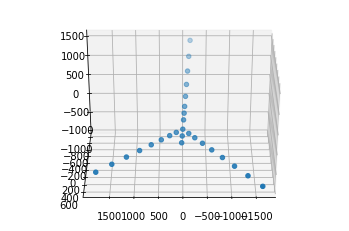

In [63]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data['l_y'],data['l_x'],data['l_z'])
threedee.view_init(30, 90)

## Observation Parameters

The sources are positioned as follows:

**Source 1 :**

Position: *J05 00 00 +45 00 00*

Flux Density: *3.6 Jy*

**Source 2 :**

Position: *J05 00 10 +45 03 00*

Flux Density: *5.8 Jy*



## Projection of Array for baseline length calculations.
The baselines are calculated by finding the distance between each antennas. It should here be noted that the baseline distances are calclated only once. i.e distance between antenna VA01 and VA02 is done once and the distance VA02 to VA01 is not calculated as this will introduce redundancy in our data. <code>baselines_array</code> stores the position of each antenna. While <code>baselines_labels</code> stores the labels of each pair of antennas corresponding to the baseline.

In [64]:
baselines_array=np.zeros((351,3))
baselines_labels=np.zeros((351,2))
count = 0
for i in range (0,27):
    for j in range (0,27):
        if i != j :
            if j > i:
                b_u = data['l_x'][i] - data['l_x'][j]
                b_v = data['l_y'][i] - data['l_y'][j]
                b_w = data['l_z'][i] - data['l_z'][j]
                baselines_array[count,0] = b_u
                baselines_array[count,1] = b_v
                baselines_array[count,2] = b_w
                baselines_labels[count,0] = i
                baselines_labels[count,1] = j
                count = count+1

Convert each baseline distance by converting to second and multiplying by the speed of light.

In [65]:
baselines_array=baselines_array*3*(10**8)*(10**-9)

Text(0, 0.5, 'y(m)')

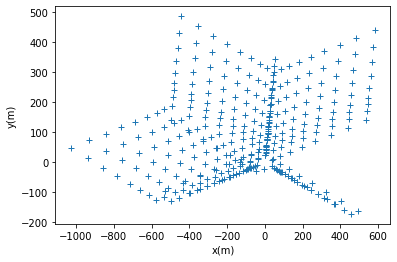

In [66]:
baselines_array
plt.plot(baselines_array[:,1],baselines_array[:,0],"+")
plt.xlabel('x(m)')
plt.ylabel('y(m)')

<code> baseline_array_rotated </code> stores the information about each baselines position as a result of the earth rotation synthesis

In [67]:
declination = np.radians(45) #Declination of the VLA
baselines_array_rotated=np.zeros((1000,5400*2,351,2)) #baelines position once earth rotation systhesis is considered

In [68]:
c = 3 * (10**8) #speed of light units m/s

## Earth Rotation Synthesis and (u,v) Frequency Dependence
### U,V plot
As both sources are perfect point sources, we can express the sky distribution using 2 dirac delta functions these can be written as:

\begin{equation*}
S(l,m) = A_0 \delta(l-l_0,m-m_0) + A_1 \delta(l-l_1,m-m_1)
\label{eq:vector_ray} \tag{1}
\end{equation*}



where $l_0 = 0$ and $m_0 = 0$ for Source 1 and $l_1 = 8.72665 x 10^{-4}$ and $m_1 = 7.27221 x 10^{-4}$ for Source 2. The visibilities in the (u,v) plane will be given by the fourier transform of those two sources which will be given as:


\begin{equation*}
f(u,v) =\int \int  A_0 \delta(l-l_0,m-m_0) e^{-2 \pi ((l-l_0)u + (m-m_0)v)} + A_1 \delta(l-l_1,m-m_1)   e^{-2 \pi ((l-l_1)u + (m-m_1)v)} dl dm
\label{eq:vector_ray_2} \tag{2}
\end{equation*}



This gives the visibility given by:

\begin{equation*}
f(u,v) = A_0 e^{-2 \pi i (l_0 u + m_0 v)} + A_1   e^{-2 \pi i (l_1 u + m_1 v)}
\label{eq:vector_ray_3} \tag{3}
\end{equation*}

Where $A_0$ is the flux intensity of the first source with flux intensity 3.6 Jy and $A_1$ is of amplitude 5.8 Jy.

In [69]:
A_0 = 3.6 #units in Jansky
A_1 = 5.8 #units in Jansky

In [70]:
l_0 = 0.0 #units radians
m_0 = 0.0 #units radians
l_1 = 0.000872665 #units radians
m_1 = 0.000727221 #units radians

### Earth Rotation Synthesis (Time and Frequency Dependency of u,v baselines)
Each baseline would be sampling from the u,v space from equation 3. Those sampling point are based on the following three factors:

1. The Baselines distance between each two antennas (Calculated from the baselines length calculation)

2. The hour angle and declination of the centre of the field of view (from -1.5 Hr to 1.5 Hr at steps of 1s)

3. The frequency at which our observation is being made (from 1.0 GHz to 2.0 GHz at steps of 0.5 MHz)

#### Hour Angle and Declination of the centre of the field-of-view

For baselines distances given by: $(X_{\lambda}, Y_{\lambda}$, $Z_{\lambda}$) where the units are in metres and measured in $\lambda$, the component $(u,v,w)$ will be given by:

\begin{equation*}
\begin{bmatrix}
u \\
v\\
w
\end{bmatrix} =
\begin{bmatrix}
 sin H(t) & cos H(t) & 0\\ 
 -sin \delta cos H(t) & sin \delta sin H(t) & cos \delta\\ 
 cos \delta cos H(t) & -cos \delta sin H(t) & sin \delta
\end{bmatrix}
\begin{bmatrix}
X_{\lambda} \\
Y_{\lambda}\\
Z_{\lambda}
\end{bmatrix}
\label{eq:vector_ray_3} \tag{4}
\end{equation*}

Source : Thompson et al.(2001)
#### Frequency Dependence

\begin{equation*}
X_{\lambda} = x \frac{\nu}{c}
\label{eq:vector_ray_3oiu} \tag{5}
\end{equation*}

\begin{equation*}
Y_{\lambda} = y \frac{\nu}{c}
\label{eq:vector_ray_3oytuiu} \tag{6}
\end{equation*}

\begin{equation*}
Z_{\lambda} = z \frac{\nu}{c}
\label{eq:vector_ray_3oytuidsfu} \tag{7}
\end{equation*}

We can thus replace the equation 6 and 5 in equation 4 to finally express the $u$ and $v$:

\begin{equation*}
u(t,\nu) = \left(  x \sin H(t) + y \cos H(t) \right) \frac{\nu}{c}
\label{eq:vector_ray_3oytuifddsfu} \tag{7}
\end{equation*}

\begin{equation*}
v(t,\nu) = \left(  -x \sin \delta cos H(t) + y \sin \delta sin H(t) + z \cos \delta \right) \frac{\nu}{c}
\label{eq:vector_ray_3oytuihhfddsfu} \tag{8}
\end{equation*}

Creates linspace for frequency from 1.0 to 2.0 GHz at step of 0.5 MHz and linspace for frequency from -22.5 degrees to 22.5 degrees (for the 3 hour observation) at steps of 1 second.

In [71]:
freq_ghz = np.linspace(1.0, 2.0, 2000)*(10**9) #units GHz
time_1d = np.linspace(-22.5,22.5,10800) #units Degrees

In [72]:
hour_angle = np.radians(time_1d) #convert hour angle to radians

In [73]:
time, freq = np.meshgrid(hour_angle, freq_ghz) #meshes grids of Frequency(Hz) and Hour Angle(Radians)

We here create the <code>baselines_observations</code> 3D array that stores the baselines observation. The Array is of dimension 351 by 2000 by 10800. The first dimension corresponds to the 351 baselines observations that can be obtained by the VLA in D configuration. The second dimension corresponds to the number of channels which is 2000 corresponding to a channel width of 0.5 MHz each, Finally the final dimension corresponds to each second of the observation over the 3 Hour observation. It should here be noted that the baseline observation is the absolute value of the baseline observation which is calculated using equation 3.

In [74]:
baselines_observations = np.zeros((351,2000,10800))

In [75]:
for baseline_index in range(0,350):
    u = ((baselines_array[baseline_index,0] * np.sin(time)) + (baselines_array[baseline_index,1] * np.cos(time))) * (freq/c)
    v = ((baselines_array[baseline_index,0] * (-1*(np.sin(declination))*(np.cos(time)))) + (baselines_array[baseline_index,1] * ((np.sin(declination))*(np.sin(time))))+(baselines_array[baseline_index,2] * np.cos(declination))) * (freq/c)
    baselines_observations[baseline_index,:,:] = abs((A_1*(np.exp(-2.0*np.pi*1.0j*((l_1*(u))+(m_1*(v))))))+(A_0*(np.exp(-2.0*np.pi*1.0j*((l_0*(u))+(m_0*(v)))))))
    IPython.display.clear_output()
    print('Working with baseline:'+str(baseline_index))

Working with baseline:349


## Dynamic Spectra Samples

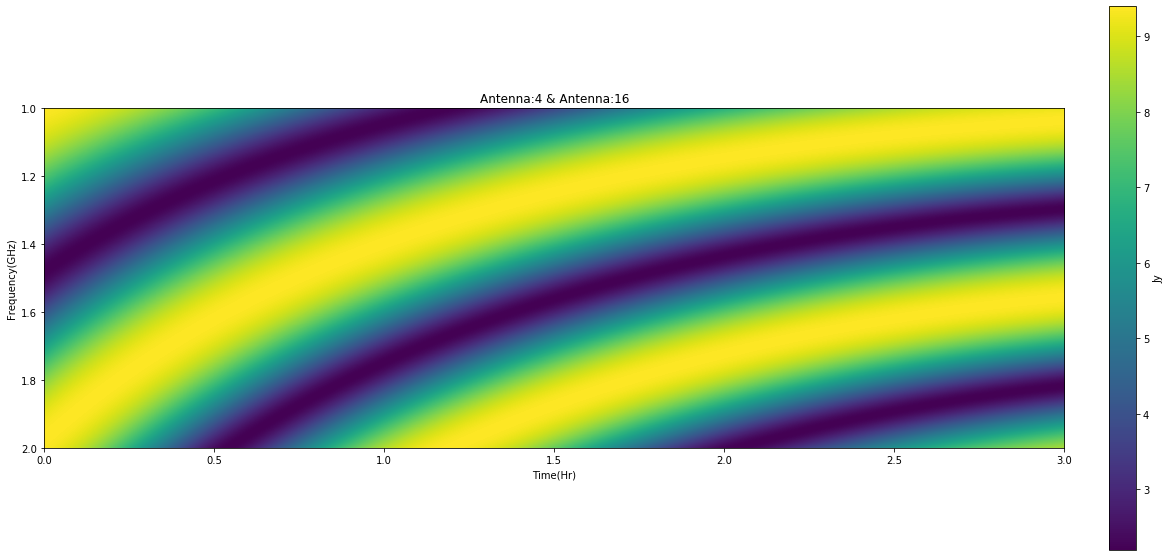

In [76]:
baseline_observation_id = 109
extent=[0,3,2,1]
plt.figure(figsize=(20,10))
plt.xlabel('Time(Hr)')
plt.ylabel('Frequency(GHz)')
plt.title('Antenna:'+str(int(baselines_labels[baseline_observation_id,0]))+' & Antenna:'+str(int(baselines_labels[baseline_observation_id,1])))
plt.imshow(baselines_observations[baseline_observation_id,:,:],extent=extent)
plt.colorbar(fraction=0.046, pad=0.04,orientation="vertical",label='Jy')

# Radio Frequency Interference Adder

## Classes of Radio Frequency Interference
In this work, we first break down the RFI into three groups based on their Classification maked by NRAO (2015). These are 1. Continueous, 2. Intermitent and 3.Malfunction. These are further broken down into subclasses. The Continueous Signals are sub-divided to GPS and GLONASS (L1,L2 and L5), Modem (Which consists only of the VLA Modem), Radars (Which consists of 7 Radars) and finally PCS Cell Phone base Stations.

Each group will have a particuar modulation and thus a specific dymamic spectra. We make use of DeepSig Database to model the modulation of each type this is given in the <code>rfi_schedule.csv</code> pandas dataframe 

These continueous signals will be present throughout our observation. The Second Class of Radio Frequency interference will be the intermitent one. These are added randomly to the data. They are subclassified as follows: 1. Communications, Radar, Transponder, High Altitude Baloon and Weather Satellites. The final class are classified as Malfunction and are mostly AEROSTAT.

Note: A_1 tp A_25 defines what RFI is affecting what baselines. In our case as the Array have a compact configuration we will assume that all RFI will affect the Antenna equally.

In [77]:
data_rfi_info = pd.read_csv('rfi_schedule.csv')

In [78]:
data_rfi_info[0:5] #change to data_rfi_info to print all RFIs

,rfi_id,name,Cat_1,Cat_2,modulation,start_freq,end_freq,A_1,A_2,A_3,...,A_16,A_17,A_18,A_19,A_20,A_21,A_22,A_23,A_24,A_25
0,1,ratscat_low_fq,intermittent,radar,AM-SSB,1000,1000,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2,aircraft_navigation_dme,intermittent,communication,BPSK,1025,1150,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,3,aeronautical_iff_gnd2air,intermittent,communication,BPSK,1030,1030,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,4,aeronautical_iff_air2gnd,intermittent,communication,BPSK,1090,1090,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,5,GPS_galileo,Continueous,GPS_Satellite,BPSK,1166,1186,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## DeepSig RFI Database
DeepSig (O'Shea et al. (2018)) is a dataset of Radio Frequency Interference that are classified in 11 classes. 
1. 8PSK(Eight Phase Shift Keying)
2. AM-DSB (Amplitude Modulation Double Side Band)
3. AM-SSM (Amplitude Modultaion Single Sideband)
4. BPSK (Binary Phase Shift Keying)
5. CPFSK (Continueous Phase Frequency Shift Keying)
6. GFSK (Gaussian Frequency Shift Keying)
7. PAM4 (Pulse Amplitude Modulation)
8. QAM16 (16 bit Quadrature Amplitude Modulation)
9. QAM64 (64 bit Quadrature Amplitude Modulation)
10. QPSK (Quadrature Phase Shift Keying)
11. WBFM (Wide Band frequency Modultation)

The data is generated taking into consideration the modulation type of the signal as well as several diverse propagagtion scenarios (O'Shea et al. (2018)). They use random values for the channel response envelope, the delay spread and deviation from the fundamental frequency of the carrier. Each data sample are a time series of length $l =$ 1024 and the dataset consist of 22,000 times series where each of the 11 classes consist of 2,000 RFI times series with varying signal-to-noise ratio.

For the purpose of our RFI mitigation, the fourier transfor of these signals are used. When we perform the fast fourier transform, we adjust the sampling frequency to 10MHz, this gives us an RFI band of 10MHz.

The RFI is vaired randomly every 20 sec for each VLA RFI type and the dynamic spectra is added at the frequency of the RFI.

In [8]:
url='http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2'

In [10]:
urllib.request.urlretrieve(url, 'RML2016.10a.tar.bz2')

('RML2016.10a.tar.bz2', <http.client.HTTPMessage at 0x11fcf4690>)

In [13]:
fname = 'RML2016.10a.tar.bz2'

In [16]:
tar = tarfile.open(fname, "r:bz2")
tar.extractall()
tar.close()

In [18]:
with open('RML2016.10a_dict.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    Xd = u.load()
    
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

<code>rfi_slot_generator</code> : calculates the slots where the intermittent RFI should be placed the whole 3 Hr is broken down into 540 slots which corresponds to 20s each. It randonly assign a starting position for the RFI, it also ensure that the RFI is not added twice in the same slot. The Starting time is randonly choosen between 10 min and 1 hr. Which means that any intermittent RFI can start from 10 min to 1 hour after the beginning of our observation. The length of the RFI is set as a random number beetween 33 min to 50 min. The specific RFI can then re-appear afterwards and the duration between each events will be between 10 min to 16 min. The function takes no parameters but returns a panda dataframe with all the start_time and end_time of a particular Intermittent RFI.  

In [80]:
def rfi_slot_generator():
    rfi_slot = np.zeros((540,2)).astype('int')
    dataset = pd.DataFrame({'start_time': rfi_slot[:, 0], 'end_time': rfi_slot[:, 1]})
    starting_position = np.random.randint(30,200)
    for i in range (0,540):
        dataset['start_time'][i:i+1]=starting_position
        ending_position = starting_position + np.random.randint(100,150)
        starting_position = ending_position + np.random.randint(30,50)
        dataset['end_time'][i:i+1]=ending_position
    data_rfi_slot_pos=dataset[dataset['end_time']<=540]
    return data_rfi_slot_pos

<code>rfi_generator</code>: The RFI generator does the Fourier transform of the DeepSig data and creates the dynamic spectra of that particular RFI. If the source is Contimueous, the function will add the RFI from $t=$0 to $t=$3 Hr. The function takes a random RFI signal for a particular modulation typ every 20 s (i.e each of the 540 slots). This introduces a randomness in the intermittent RFI signal. For intermittent signals, the function takes in the position of the RFI which is found in the pandas dataframe generated by <code>rfi_slot_generator</code> the pandas dataframe is parsed as a paramter in the function and is denoted as <code>slot_dataframe</code>

In [81]:
def rfi_generator(slot_dataframe,type1,modulation_type):
    modulation_dictionary = {
        '8PSK' : 0,
        'AM-DSB' : 20000,
        'AM-SSB' : 40000,
        'BPSK': 60000,
        'CPFSK'  : 80000,
        'GFSK' : 10000,
        'PAM4' : 12000,
        'QAM16' : 14000,
        'QAM64' : 16000, 
        'QPSK' : 18000,
        'WBFM' : 20000} #Position of different RFI modulation types in DeepSig database
    
    
    rfi_modulation = np.zeros((10,540))
    rfi_struc = np.zeros((60*60*3,10))
    if type1=='Continueous':
        length_rfi = 1
    else:
        length_rfi = len(slot_dataframe)
        
    for x_count in range (0,length_rfi):
        if type1=='Continueous':  #If RFI is not continueous add RFI from t=0 to t=3 Hr
            j_start = 0
            j_end = 540
        else:
            j_start = slot_dataframe['start_time'][x_count:x_count+1][x_count]
            j_end = slot_dataframe['end_time'][x_count:x_count+1][x_count]                
        
        for j in range (j_start,j_end):
            y=X[modulation_dictionary[modulation_type]+(random.randint(0,19999))][0]
            N = 128           # Number of samplepoints
            Fs = 200000.0*50
            T = 1.0 / Fs      # N_samps*T (#samples x sample period) is the sample spacing.
            N_fft = 10     # Number of bins (chooses granularity)
            x = np.linspace(0, N*T, N)     # the interval
            yf = scipy.fftpack.fft(y,n=N_fft)  # Does fourier transform of signal
            xf = np.arange(0,Fs,Fs/N_fft)
            rfi_modulation[:,j]=np.abs(yf) #Takes absolute
        
            rfi_modulation[:,j]=rfi_modulation[:,j]/np.max(rfi_modulation[:,j])
    
            rfi_struc[j*20:(j*20)+20,:]=[rfi_modulation[:,j],]*20
    return rfi_struc

We here generate the Dynamic Spectra for each RFI given by NRAO(2015). We generate 56 types of RFI which originates FROM 56 differrent type of sources. Each RFI can have one specific frequency or a band of frequencies. For each of the 56 RFIs, we will create a 2000 by 10800 matrix. All the RFI are stored in <code> data_rfi_all <code>

In [82]:
columns = ['start_time','end_time', 'freq']
rfi_slotting_w_freq = pd.DataFrame(columns=columns)
data_rfi_all= np.zeros((56,2000,10800))
data_rfi_info = pd.read_csv('rfi_schedule.csv')
count = 0
for j in range (0,56): #Loops over the different RFI signa
    rfi_slotting = rfi_slot_generator() #This have to be used for RFI position in time direction
    for position_freq in range (data_rfi_info['start_freq'][j],(data_rfi_info['end_freq'][j])+1):
        rfi_data_temp = rfi_generator(rfi_slotting,data_rfi_info['Cat_1'][j],data_rfi_info['modulation'][j])
        position_freq_2=(position_freq-1000)*2
        data_test=data_rfi_all[j,:,:]
        data_test[(position_freq_2+1):(position_freq_2+11),:]=((rfi_data_temp.T)*1)+data_test[(position_freq_2+1):(position_freq_2+11),:]
        extent = [0,3,2,1]
        rfi_slotting['freq'] = position_freq
        rfi_slotting_w_freq=rfi_slotting_w_freq.append(rfi_slotting,ignore_index=True)
        count = count +1
    data_rfi_all[j,:,:] = data_test

### Plot  RFI
We here plot all the RFI as a check point to verify if the RFI generation pipe like is operating correctly

In [83]:
rfi_combined = np.zeros((2000,10800))
for j in range(0,56):
    rfi_combined = rfi_combined + data_rfi_all[j,:,:]

Text(0.5, 1.0, 'RFI Only')

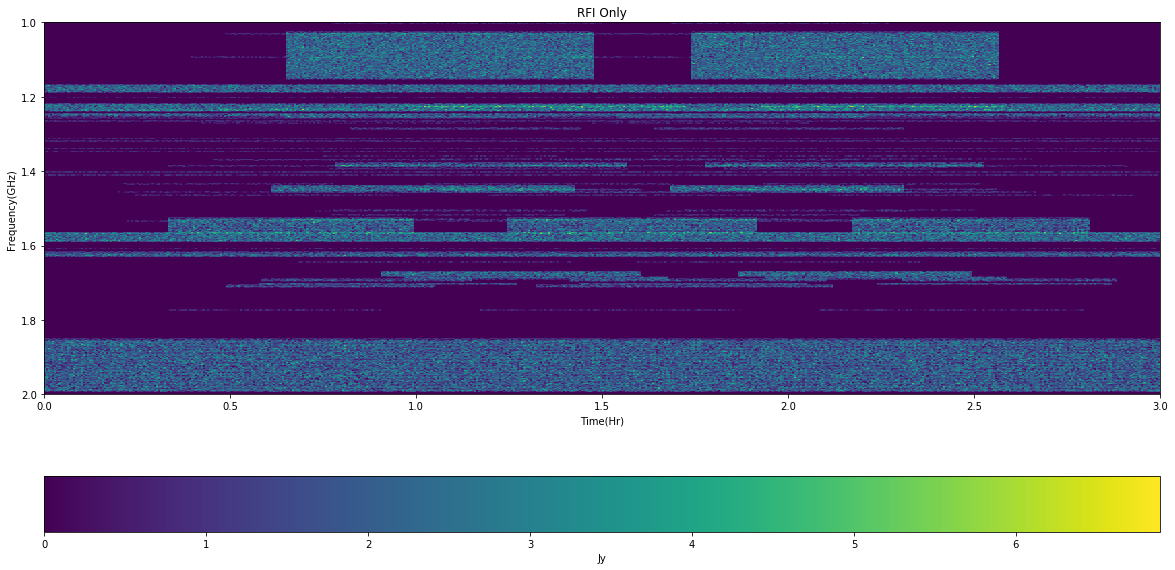

In [84]:
plt.figure(figsize=(20,10))
plt.xlabel('Time(Hr)')
plt.ylabel('Frequency(GHz)')
plt.imshow(rfi_combined,extent=extent)
plt.colorbar(orientation="horizontal",label='Jy')
plt.title('RFI Only')

# Database Generation

#### RFI Addition

In [85]:
baselines_with_rfi = np.zeros((351,2000,10800))

In [86]:
for j in range (0,351):
    baselines_with_rfi[j,:,:]=baselines_observations[j,:,:] + rfi_combined

Text(0.5, 1.0, 'Antenna:1 & Antenna:26')

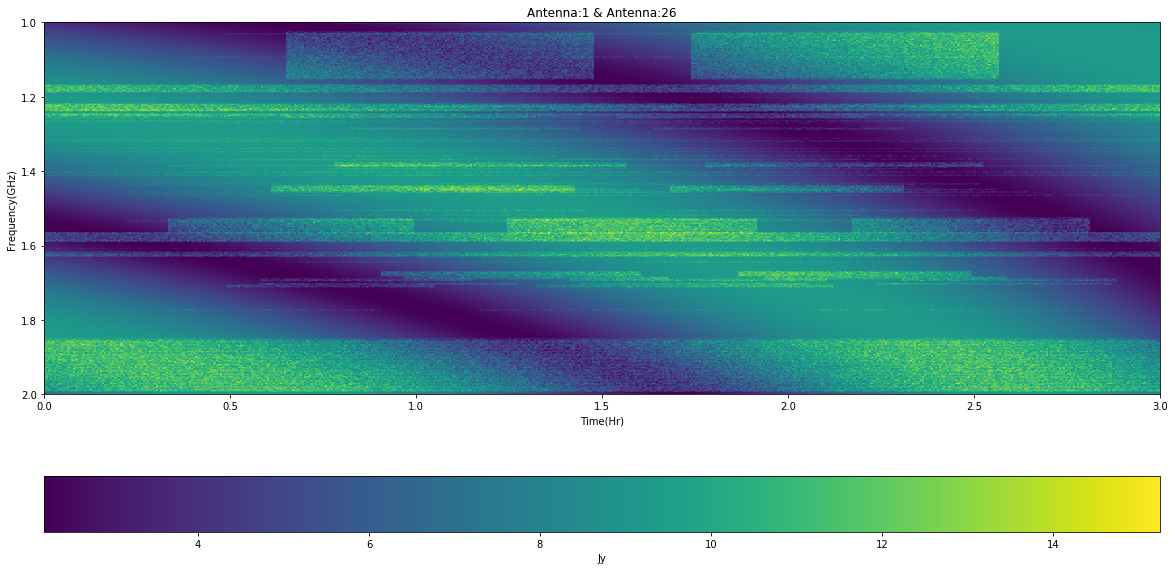

In [87]:
plt.figure(figsize=(20,10))
plt.xlabel('Time(Hr)')
plt.ylabel('Frequency(GHz)')
plt.imshow(baselines_with_rfi[50,:,:],extent=extent)
plt.colorbar(orientation="horizontal",label='Jy')
plt.title('Antenna:'+str(int(baselines_labels[50,0]))+' & Antenna:'+str(int(baselines_labels[50,1])))


# Feature Extraction and Machine Leaning Performance Evaluation

<code>feature_extractor</code> : is the function that performs the feature extraction. The function extracts 7 features from the dynamic window. 1. The Kurtosis Factor, 2.The Skewness 3.The Max of the Cumulative sum 4.The Variance 5. The 25% Percentile 6.The 75% Percentile and finally 7.The mean of the dynamic spectra window.

In [88]:
def feature_extractor(dynamic_spectra_window):
    extracted_features = np.zeros((7,))
    extracted_features[0] = kurtosis(dynamic_spectra_window.reshape(200,))
    extracted_features[1] = skew(dynamic_spectra_window.reshape(200,))
    extracted_features[2] = np.max(np.cumsum(dynamic_spectra_window))
    extracted_features[3] = np.var(dynamic_spectra_window.reshape(200,))
    extracted_features[4] = np.percentile(dynamic_spectra_window.reshape(200,), 25)
    extracted_features[5] = np.percentile(dynamic_spectra_window.reshape(200,), 75)
    extracted_features[6] = np.mean(dynamic_spectra_window.reshape(200,))
    return extracted_features

<code>feature_extraction_baselines</code> : The function makes use of <code>feature_extractor</code>, it first extract the RFI features by moving a 20 by 10 window over the RFI Signals (the position of the RFI is stored in <code>rfi_slotting_w_freq</code>. It then repeats the same process of feature extraction by randomly sampling from the baselines __without__ the RFI, in such a case it is able to extract Non-RFI features. Due to computational contrainst, we limit ourself to only 2 baselines but this is enough data to generalise on all baselines. The extracted features are then shuffled to reduce any bias in the training process by the Machine Learning algorithm.

In [89]:
def feature_extraction_baselines(number_of_baselines,noise_parameters):
    length_of_feature_vec = len(rfi_slotting_w_freq)*number_of_baselines*10
    rfi_extracted_features = np.zeros((length_of_feature_vec,7))
    rfi_spectra = np.zeros((10,20))
    count = 0
    mu, sigma, amplitude = noise_parameters
    noise_matrix = np.random.normal(mu, sigma, (2000,10800))
    for baseline_id_2 in range (0,number_of_baselines):
        data_to_extract_features = baselines_with_rfi[baseline_id_2,:,:]+(amplitude*noise_matrix)
        for id_rfi in range (0,len(rfi_slotting_w_freq)):
            position_freq = rfi_slotting_w_freq['freq'][id_rfi]
            position_freq_2=((position_freq-1000)*2)
            time_position=np.random.randint(rfi_slotting_w_freq['start_time'][id_rfi],
                                            rfi_slotting_w_freq['end_time'][id_rfi],(10,))
            for j in range (0,10):
                rfi_feature_to_Ex=data_to_extract_features[position_freq_2+1:position_freq_2+11,time_position[j]*20:(time_position[j]*20)+20]
                rfi_spectra = rfi_feature_to_Ex
                rfi_extracted_features[count,:] = feature_extractor(rfi_spectra)
                count = count+1
        IPython.display.clear_output()
        print('Extracting RFI Features for baseline Id:'+str(baseline_id_2))
    
    non_rfi_extracted_features = np.zeros((length_of_feature_vec,7))
    count_main = 0
    for baseline_id_2 in range (0,number_of_baselines):
        count = 0
        while count < len(rfi_slotting_w_freq):
            data_to_extract_features = baselines_observations[baseline_id_2,:,:]+(amplitude*noise_matrix)
            position_freq = random.randint(1000,1800)
            time_position = np.random.randint(0,540,(10,))
            for j in range (0,10):   
                position_freq_2=((position_freq-1000)*2)
                non_rfi_spectra = data_to_extract_features[position_freq_2+1:position_freq_2+11,time_position[j]*20:(time_position[j]*20)+20]
                non_rfi_extracted_features[count_main,:] = feature_extractor(non_rfi_spectra)
                count_main = count_main +1
            count = count+1
        IPython.display.clear_output()
        print('Extracting Non-RFI features for baseline Id:'+str(baseline_id_2))

    rfi_labels = np.zeros((rfi_extracted_features.shape[0]*2,))
    data = np.vstack((non_rfi_extracted_features,rfi_extracted_features))
    rfi_labels[rfi_extracted_features.shape[0]:rfi_extracted_features.shape[0]*2]=1
    rfi_labels_2=rfi_labels.reshape(rfi_extracted_features.shape[0]*2,1)
    data_new=np.append(data,rfi_labels_2,axis=1)
    np.random.shuffle(data_new)
    data=data_new
    return data_new

# Machine Learning Classification and Performance Evaluation

## Feature Evaluation

We visualise the features by using pair plots to ensure that the fatures have been corectly engineered as we are dealing with only 7 features, a dimensionality reduction is not required for the feature visualisation. To reduce the processing time we limit our training data to 4000 datapoints which is enough to train the algorithm and enough for inference purposes.

We do our evaluation with a noise of 5 Jy. The Noise has guassian parameters $\mu =0$ and $\sigma=0.2$

In [90]:
data_new=feature_extraction_baselines(2,[0,0.2,5])
X=data_new[0:4000,0:7]
y=data_new[0:4000,7]

Extracting Non-RFI features for baseline Id:1


<Figure size 432x288 with 0 Axes>

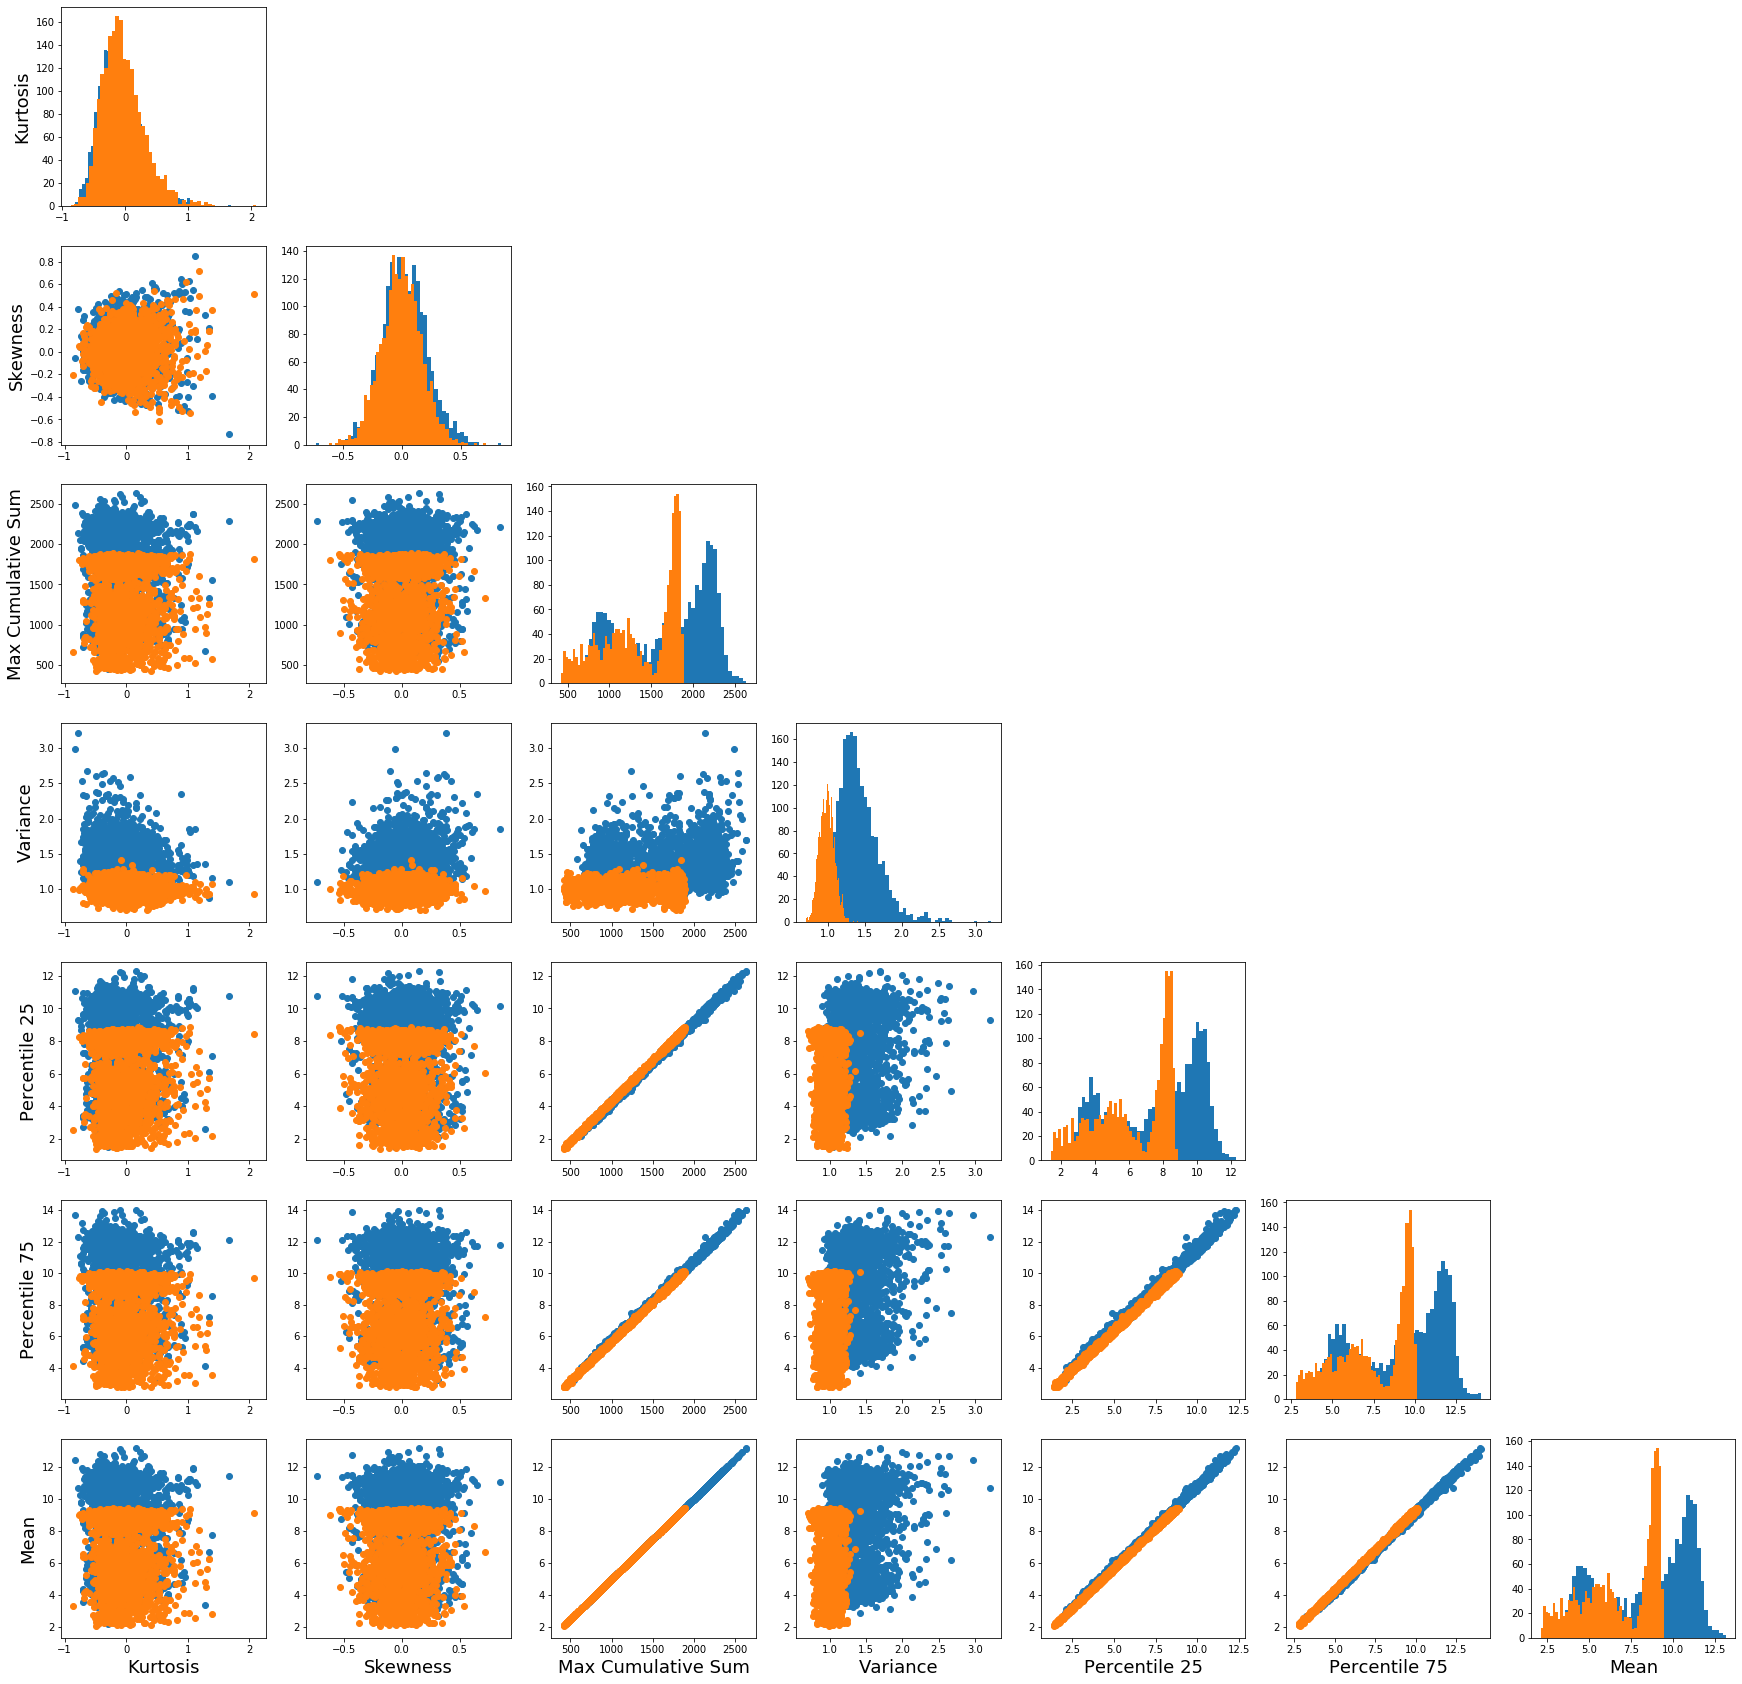

In [91]:
plt.figure(0)
plt.figure(figsize=(30,30))
plots = []

labels = {
    0: 'Kurtosis',
    1: 'Skewness' ,
    2: 'Max Cumulative Sum' ,
    3: 'Variance' ,
    4: 'Percentile 25' ,
    5: 'Percentile 75' ,
    6: 'Mean'
}

for i in range(0,7):
    for j in range(0,7):
        if (j <= i) and (i != j):
            ax = plt.subplot2grid((7,7), (i,j))
            ax.scatter(X[y == 1][:,j],X[y == 1][:,i])
            ax.scatter(X[y == 0][:,j],X[y == 0][:,i])
                
                
        if j == i:
            ax = plt.subplot2grid((7,7), (i,j))
            ax.hist(X[y == 1][:,j], bins = 50)
            ax.hist(X[y == 0][:,j], bins = 50)
            
            
        if j == 0:
            plt.ylabel(labels.get(i),fontsize=18)
                
        if i == 6:
            plt.xlabel(labels.get(j),fontsize=18)
plt.show()

## Receiver Operating Characteristic (ROC) Evaluation 
For our first evaluation we make us of 3 algorithms:1. Random Forest Classifier Liaw and Weiner(2002) 2. Gaussian NB and 3.K-Nearest Neighbour. To evaluate the algorithms, we first plot the Receiver Operating Characteristic (ROC) and perform 6-fold cross validation on our dataset and mean ROC of each folds is plotted as shown below. Everything is implemented using sklearn (Pedregosa et al.(2011)

In [92]:
random_state = np.random.RandomState(0)

cv = StratifiedKFold(n_splits=6)


classifier_1 = RandomForestClassifier(n_estimators=10000, max_depth=3,random_state=random_state)
classifier_2 = GaussianNB()
classifier_3=neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')

In [93]:
def plot_roc(classifier,classifier_name):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
            probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic '+classifier_name)
    plt.legend(loc="lower right")

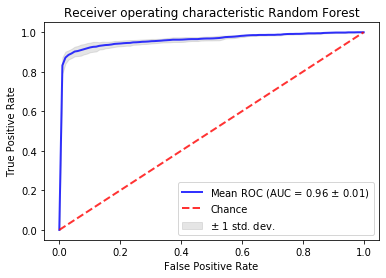

In [94]:
plot_roc(classifier_1,'Random Forest')

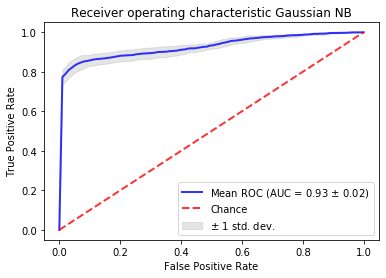

In [95]:
plot_roc(classifier_2,'Gaussian NB')

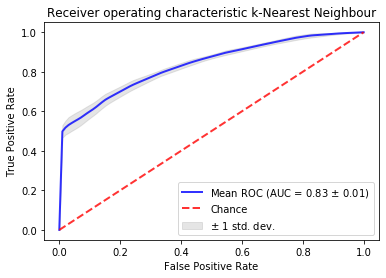

In [96]:
plot_roc(classifier_3,'k-Nearest Neighbour')

## Performance Evaluation for Varying SNR

We evaluate the algorithm performance for different signal to noise ratio. The SNR is varied from -1 dB to 1dB. We plot the Precision, Recall, Accuracy and F1 Score for each SNR

In [97]:
noise_db = -1.0
accuracy = np.zeros((20,))
precision = np.zeros((20,))
recall = np.zeros((20,))
f1_score = np.zeros((20,))
for i in range (0,20):
    print('Feature Extraction for SNR '+str(noise_db)+' dB')
    noise_db = noise_db +0.1
    noise = 9.4 *(10**(-1*(noise_db/10.0)))
    data_new=feature_extraction_baselines(2,[0,0.2,noise])
    X=data_new[0:4000,0:7]
    y=data_new[0:4000,7]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.25,random_state=random_state)

    classifier_1.fit(X_train, y_train)
    y_score = classifier_1.predict(X_test)
    average_precision = average_precision_score(y_test, y_score)
    tn, fp, fn, tp = confusion_matrix(y_test, y_score).ravel()
    accuracy[i] = (tp+tn)/(tp+tn+fp+fn)
    precision[i] = tp / (tp+fp)
    recall[i] = tp /(tp+fn)
    f1_score[i] = (2*precision[i]*recall[i])/(precision[i]+recall[i])

Extracting Non-RFI features for baseline Id:1


In [98]:
noise_db = np.linspace(-1, 1, 20)

Text(0.5, 1.0, 'SNR Performance comparison')

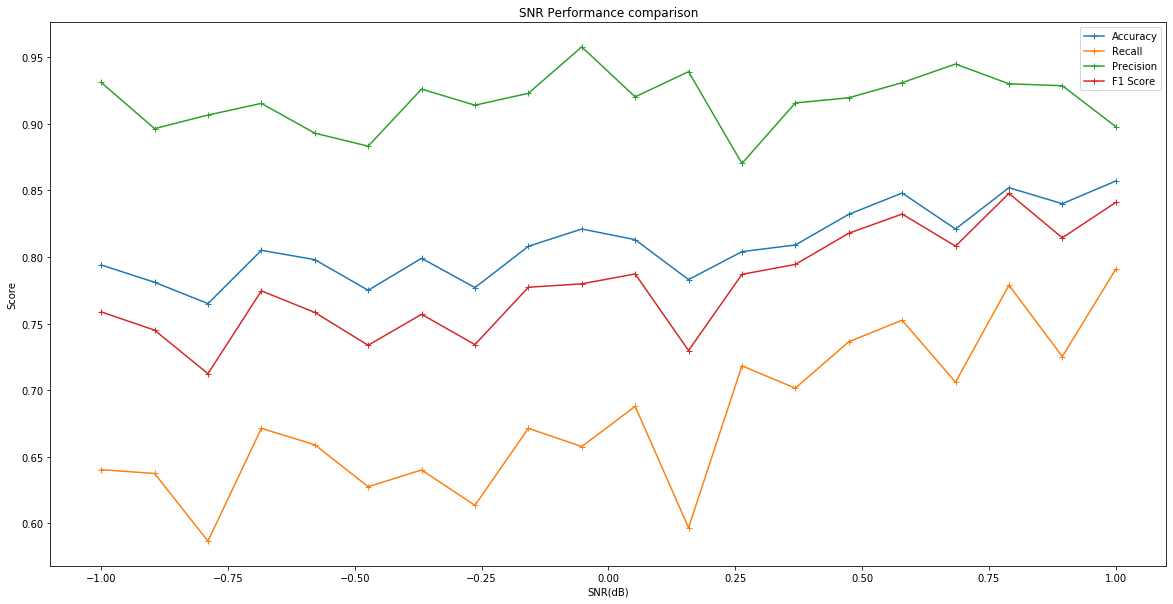

In [99]:
plt.figure(figsize=(20,10))
plt.plot(noise_db,accuracy,'-+',label='Accuracy')
plt.plot(noise_db,recall,'-+',label='Recall')
plt.plot(noise_db,precision,'-+',label='Precision')
plt.plot(noise_db,f1_score,'-+',label='F1 Score')
plt.legend()
plt.xlabel('SNR(dB)')
plt.ylabel('Score')
plt.title('SNR Performance comparison')

Note: While the Precision tend to remain quite stable, an increase in the other parameters Accuracy, Recall and F1 Score is observed. As the dataset is balanced, the Accuracy can be used as a performance indicator showing that the algorithm can more easily distinguish between RFI and Non-RFI at low SNR.

# Inference and RFI Mitigation
We test our algorithm of a baseline that was not used for classification and set the SNR to 10 dB with a mean of 0 and a std of 0.2. Only one intermittent RFI is added to the Dynamic Spectra for inference purposes.

In [100]:
noise = 9.4 *(10**(-1*(10./10.0)))
data_new=feature_extraction_baselines(2,[0,0.2,noise])

Extracting Non-RFI features for baseline Id:1


In [101]:
mu, sigma, amplitude = [0,0.2,noise]
noise_matrix = np.random.normal(mu, sigma, (2000,10800))

In [102]:
data_inference = baselines_observations[310,:,:] +data_rfi_all[23,:,:]+(amplitude*noise_matrix)

Plot of the baseline with Intermittent RFI to be mitigated

Text(0.5, 1.0, 'Antenna:1 & Antenna:22')

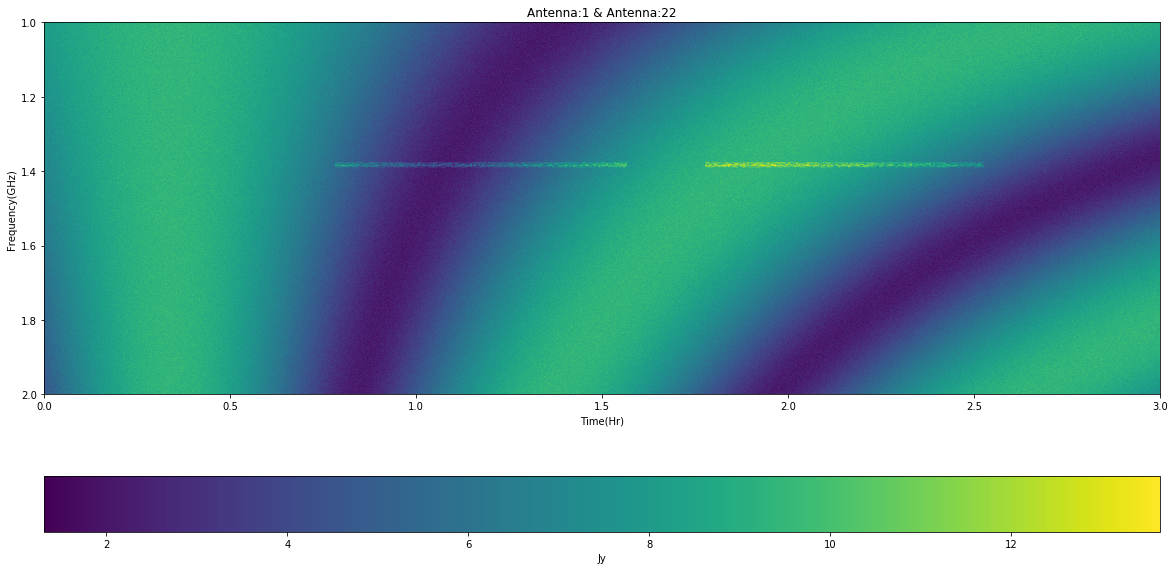

In [103]:
plt.figure(figsize=(20,10))
plt.xlabel('Time(Hr)')
plt.ylabel('Frequency(GHz)')
plt.imshow(data_inference,extent=extent)
plt.colorbar(orientation="horizontal",label='Jy')
plt.title('Antenna:'+str(int(baselines_labels[31,0]))+' & Antenna:'+str(int(baselines_labels[310,1])))

<code>inference_heat_map</code> will store the heat map of the RFI. Regions with the most RFI will have a higher probability this thus defined the regions where the RFI should be blanked out. <code>inference_feature_vec</code> stores the feature of the baseline to which the inference will be done

In [104]:
inference_heat_map = np.zeros((200,540))
inference_feature_vec = np.zeros((7,200,540))

Performs the feature extraction process of the baseline in which the RFI will be detected

In [105]:
for j in range (0,540):
    for i in range (0,200):
        data_to_infer =  data_inference[(10*i):(10*i)+10,(20*j):(20*j)+20]
        inference_feature_vec[:,i,j] = feature_extractor(data_to_infer)

Trains Machine Learning Algorithm using a new set of training data with noise similar to our inference baseline

In [106]:
data_new=feature_extraction_baselines(2,[0,0.2,noise])
X=data_new[0:4000,0:7]
y=data_new[0:4000,7]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.25,random_state=random_state)

Extracting Non-RFI features for baseline Id:1


In [107]:
classifier_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False,
                       random_state=RandomState(MT19937) at 0x7FA8F052D468,
                       verbose=0, warm_start=False)

Predicts the RFI score or the probability of a window having an RFI

In [108]:
y_score = classifier_1.predict_proba(inference_feature_vec.reshape((7,540*200)).T)

Text(0, 0.5, 'Frequency(GHz)')

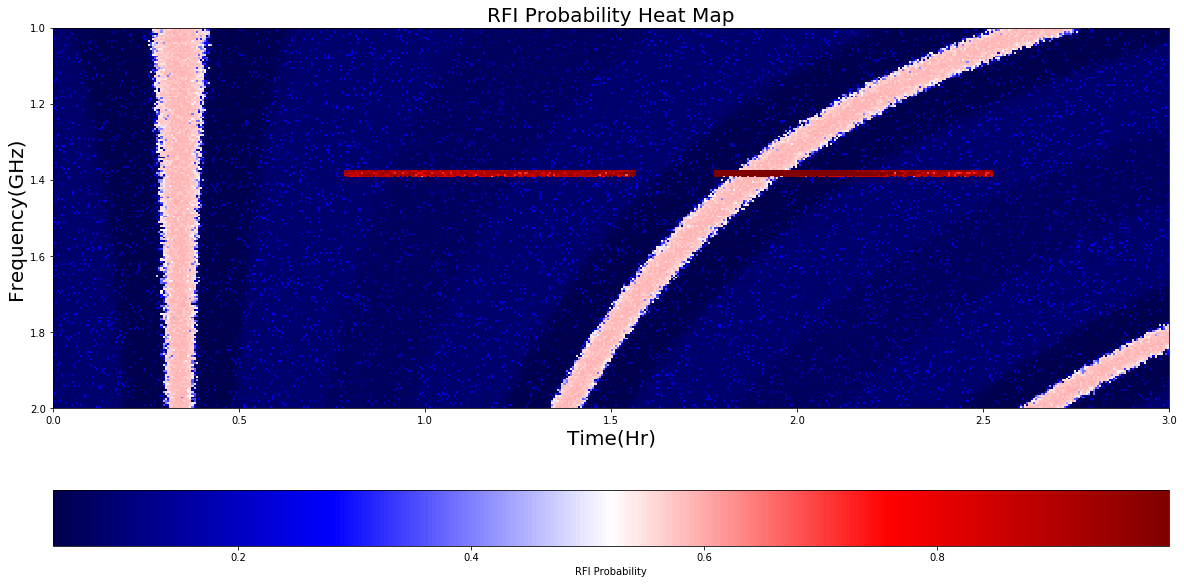

In [109]:
plt.figure(figsize=(20,10))
plt.imshow(y_score[:,1].reshape(200,540),cmap=plt.get_cmap('seismic'), aspect ='auto',extent=extent)
plt.colorbar(orientation="horizontal",label='RFI Probability')
plt.title('RFI Probability Heat Map',fontsize=20)
plt.xlabel("Time(Hr)", fontsize=20)
plt.ylabel("Frequency(GHz)", fontsize=20)

Note: We can here clearly distinguish that the RFI is highlighted by the algorithm as having probability greater that 80%. The Dynamic spectra is still highlighted as high probability but it is here noted that if a threshold of 80% is used then the source information will not be blanked out.

## RFI Excision
We excise the RFI by blanking the regions where the RFI probability is greater that 80%

In [110]:
data_rfi_only = np.zeros((2000,10800))
data_inference_2=data_inference.copy()
inference_scores=y_score[:,1].reshape(200,540)
for j in range (0,540):
    for i in range (0,200):
        if inference_scores[i,j] > 0.80:
            data_inference_2[(10*i):(10*i)+10,(20*j):(20*j)+20] = 0

Text(0.5, 1.0, 'Antenna:1 & Antenna:22 after RFI Mitigation')

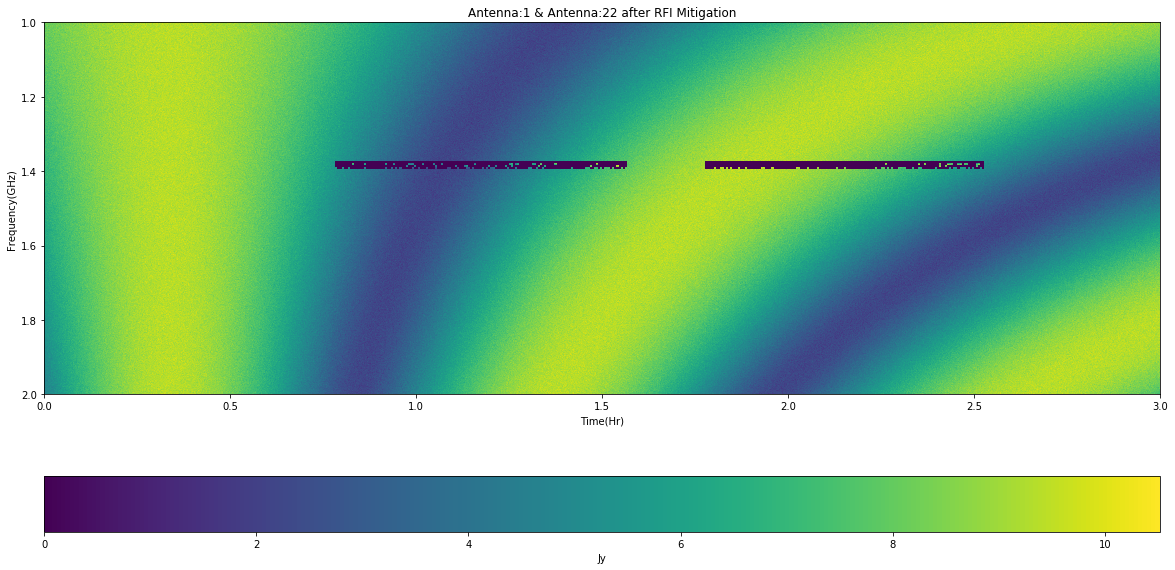

In [111]:
plt.figure(figsize=(20,10))
plt.xlabel('Time(Hr)')
plt.ylabel('Frequency(GHz)')
plt.imshow(data_inference_2,extent=extent)
plt.colorbar(orientation="horizontal",label='Jy')
plt.title('Antenna:'+str(int(baselines_labels[31,0]))+' & Antenna:'+str(int(baselines_labels[310,1]))+' after RFI Mitigation')

# Conclusion
We have here showed that Machine Learning methods that were previously brought forward by Mosiane et al.(2017) applied to KAT7 data can be used for the removal of RFI from VLA D-Configuration L-band simulated dynamic spectral data. The methods have various advantages and disadvantages that are here presented:

## Advantages 
1. The algorithm can be used and is more adequate for RFI removal of observation made with large amount of Channels. We here present a method that can be used for 2000 channels each with a width of 0.5 MHz.

2. The algorith need not be trained on all the baselines and as we have seen in our demonstration only 4000 datapoints can be used for training and the model indeed can generalise to more that 2 baselines. This represents a huge advantage in cases where the required computing power is not available.

3. The method can be used for real time RFI mitigation. In our case a window of 20 sec is used. Thus the RFI mitigation can be done in real time every 20 sec.

4. The algorithm can still perform well with high signal to noise ratio (-1 dB and lower)

5. If other RFIs (than that mentioned in NRAO(2015)) affect the observation, the algorithm will still be able to detect the RFI provided that the modulation is similar to that used in the DeepSig dataset. This is due to the fact that the method makes abstration of the frequency of the RFI but rather focuses on the statistical characteristic of its dynamic spectra.

## Disadvantages
1. Even though the RFI is easily detected, the excision is done by blanking out the RFI which mean that part of the source data is still loss. However an interpolation technique can be used to fill in the blank slots left when the RFI is blanked.


## References
Condon,J,J, Cotton,W,D Greisen, E,W, Yin,Q,F, Perley,R,A, Taylor,G,B, Broderick,J,J (1998). 'The NRAO VLA Sky Survey', _The Astronomical Journal_ ,115

Liaw,A and Wiener,M. (2002). Classification and Regression by randomForest. _R News_ 2(3), 18--22


Moisiane,O, Oozeer,N, Aniyan, A, Bassett, A,B, (2017). 'Radio Frequency Interference Detection using Machine Learning', _IOP Conference Series: Materials Science and Engineering_ , 198

NRAO 2015, An Overview of the VLA, NRAO, viewed 01 Dec 2019,   <https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview>.

Offringa, A. R., de Bruyn, A. G., Biehl, M., Zaroubi, S., Bernardi, G., Pandey, V. N., (2010) Post-correlation radio frequency interference classification methods, _Monthly Notices of the Royal Astronomical Society_ , Vol 405

 O'Shea T. Tamoghna R,Charles Clancy T. (2017),Over-the-Air Deep Learning Based Radio Signal Classification, _IEEE Journal of Selected Topics in Signal Processing_ , Vol 12.
 

Pedregosa,F. Varoquaux,G. Gramfort,A. Michel,V. Thirion,B. Grisel,O. Blondel,M. Prettenhofer,P. Weiss,R. Dubourg,V. Vanderplas,J. Passos,A. Cournapeau,D. Brucher,M. Perrot,M. Duchesnay,E. Scikit-learn: Machine Learning in Python, _Journal of Machine Learning Research_, 12, 2825-2830 (2011)

Thompson, A R. Moran J,M. Swerson Jr G,E 2001, Interferometry and Synthesis in Radio Astronomy, Springer Open, ISBN:978-0-471-25492-8